In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval

## Data sample
Found on [Kaggle](https://www.kaggle.com/rounakbanik/the-movies-dataset), collected from [TMDB](https://www.themoviedb.org/?language=en) and [GroupLens](https://grouplens.org/datasets/movielens/latest/).

In [2]:
df = pd.read_csv('data/movies_metadata.csv',dtype={'original_language': 'str','poster_path': 'str'},low_memory=False)
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [3]:
#df.head()

In [4]:
df.shape

(45466, 24)

Approx 45k movies with 24 features 

### Some cleanup

Largely taken from [this notebook](https://www.kaggle.com/rounakbanik/the-story-of-film) accompanying dataset on [Kaggle](https://www.kaggle.com/rounakbanik/the-movies-dataset).

In [5]:
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')
df['revenue'] = df['revenue'].replace(0, np.nan)
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['budget'] = df['budget'].replace(0, np.nan)
df = df.drop(['original_title'], axis=1)
df = df.drop(['poster_path'], axis=1)
df = df.drop('adult', axis=1)


Add new feature -- percent profit

In [6]:
df['return'] = df['revenue'] / df['budget']
df['budget'] = df['budget'].replace(0, np.nan)
df[df['return'].isnull()].shape

(40085, 22)

Parse year

In [7]:
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
df['year'] = pd.to_numeric(df['year'], errors='coerce')

Clean up the json stuff

In [8]:
df['genres'] = df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

Reception

In [9]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [10]:
df['popularity'] = df['popularity'].apply(clean_numeric).astype('float')
df['vote_count'] = df['vote_count'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].apply(clean_numeric).astype('float')

In [11]:
df.shape

(45466, 23)

### Add credits data

In [12]:
credits = pd.read_csv('data/credits.csv')

In [13]:
credits['id'] = credits['id'].astype('int')

In [14]:
df=df[df['id']!='1997-08-20']#bug in data?
df=df[df['id']!='2012-09-29']#bug in data?
df=df[df['id']!='2014-01-01']#bug in data?

In [15]:
credits['id'] = credits['id'].astype('int')
df['id'] = df['id'].astype('int')

In [16]:
df = df.merge(credits, on='id')

In [17]:
df.shape

(45538, 25)

In [18]:
df['cast_size'] = df['cast'].apply(lambda x: len(x))
df['crew_size'] = df['crew'].apply(lambda x: len(x))

### Take only the features I want for the rest

In [19]:
md=df[['id','title','year','return','budget','runtime','cast_size','crew_size','popularity','vote_count', 'vote_average']]

In [20]:
md.shape


(45538, 11)

## Construct Bracket

In [21]:
def make_match(md, title1, title2, title1win):
    df1=md[(md['title']==title1) & (md['year'] > 1989) & (md['year'] < 2000)]
    #df1=md[(md['title'].str.contains(title1)) & (md['year'] > 1989) & (md['year'] < 2000)]
    df1 = df1.add_suffix('_1')
    df1 = df1.reset_index(drop=True)

    df2=md[(md['title']==title2) & (md['year'] > 1989) & (md['year'] < 2000)]
    #df2=md[(md['title'].str.contains(title2)) & (md['year'] > 1989) & (md['year'] < 2000)]
    df2 = df2.add_suffix('_2')
    df2 = df2.reset_index(drop=True)

    my_match=df1.join(df2)

    my_match['title_1_wins']=title1win
        
    return my_match

In [22]:
#Round 1
my_match = make_match(md, "Pulp Fiction", "Wild at Heart", 1)
my_match = my_match.append( make_match(md, "Out of Sight", "Saving Private Ryan", 0) )
my_match = my_match.append( make_match(md, "Toy Story", "The Sixth Sense", 1) )
my_match = my_match.append( make_match(md, "Schindler's List", "The Iron Giant", 1) )
my_match = my_match.append( make_match(md, "Fight Club", "Safe", 1) )
my_match = my_match.append( make_match(md, "Barton Fink", "Leon: The Professional", 1) )
my_match = my_match.append( make_match(md, "Chungking Express", "My Own Private Idaho", 1) )
my_match = my_match.append( make_match(md, "Jackie Brown", "Princess Mononoke", 1) )
my_match = my_match.append( make_match(md, "The Silence of the Lambs","Close-Up", 1) )
my_match = my_match.append( make_match(md, "Terminator 2: Judgment Day", "The Lion King", 1) )
my_match = my_match.append( make_match(md, "Heat", "JFK", 1) )
my_match = my_match.append( make_match(md, "Dazed and Confused", "The Player", 1) )
my_match = my_match.append( make_match(md, "Boogie Nights", "Naked", 1) )
my_match = my_match.append( make_match(md, "Malcolm X", "Blue", 1) )
my_match = my_match.append( make_match(md, "The Big Lebowski", "The Truman Show", 1) )
my_match = my_match.append( make_match(md, "Groundhog Day", "Edward Scissorhands", 1) )
my_match = my_match.append( make_match(md, "GoodFellas", "There's Something About Mary", 1) )
my_match = my_match.append( make_match(md, "Miller's Crossing", "Jurassic Park", 0) )
my_match = my_match.append( make_match(md, "Magnolia", "All About My Mother", 1) )
my_match = my_match.append( make_match(md, "Being John Malkovich", "Office Space", 1) )
my_match = my_match.append( make_match(md, "Unforgiven", "Metropolitan", 1) )
my_match = my_match.append( make_match(md, "Trainspotting", "Clueless", 1) )
my_match = my_match.append( make_match(md, "The Matrix", "The Blair Witch Project", 1) )
my_match = my_match.append( make_match(md, "Hoop Dreams", "The Thin Red Line", 1) )
my_match = my_match.append( make_match(md, "Fargo", "Dead Man", 1) )
my_match = my_match.append( make_match(md, "L.A. Confidential", "Glengarry Glen Ross", 1) )
my_match = my_match.append( make_match(md, "Before Sunrise", "The Insider", 1) )
my_match = my_match.append( make_match(md, "Eyes Wide Shut", "The Piano", 1) )
my_match = my_match.append( make_match(md, "Rushmore", "The Sweet Hereafter", 1) )
my_match = my_match.append( make_match(md, "The Shawshank Redemption", "The Usual Suspects", 1) )
my_match = my_match.append( make_match(md, "Reservoir Dogs", "Boyz n the Hood", 1) )
my_match = my_match.append( make_match(md, "Se7en", "Starship Troopers", 1) )

#Round 2
my_match = my_match.append( make_match(md, "Pulp Fiction", "Saving Private Ryan", 1) )
my_match = my_match.append( make_match(md, "Toy Story", "Schindler's List", 1) )
my_match = my_match.append( make_match(md, "Fight Club", "Barton Fink", 1) )
my_match = my_match.append( make_match(md, "Chungking Express", "Jackie Brown", 0) )
my_match = my_match.append( make_match(md, "The Silence of the Lambs", "Terminator 2: Judgment Day", 1) )
my_match = my_match.append( make_match(md, "Heat", "Dazed and Confused", 0) )
my_match = my_match.append( make_match(md, "Boogie Nights", "Malcolm X", 1) )
my_match = my_match.append( make_match(md, "The Big Lebowski", "Groundhog Day", 1) )
my_match = my_match.append( make_match(md, "GoodFellas", "Jurassic Park", 1) )
my_match = my_match.append( make_match(md, "Magnolia", "Being John Malkovich", 1) )
my_match = my_match.append( make_match(md, "Unforgiven", "Trainspotting", 1) )
my_match = my_match.append( make_match(md, "The Matrix", "Hoop Dreams", 1) )
my_match = my_match.append( make_match(md, "Fargo", "L.A. Confidential", 1) )
my_match = my_match.append( make_match(md, "Before Sunrise", "Eyes Wide Shut", 1) )
my_match = my_match.append( make_match(md, "Rushmore", "The Shawshank Redemption", 1) )
my_match = my_match.append( make_match(md, "Reservoir Dogs", "Se7en", 1) )

#Round 3
my_match = my_match.append( make_match(md, "Pulp Fiction", "Toy Story", 1) )
my_match = my_match.append( make_match(md, "Fight Club", "Jackie Brown", 1) )
my_match = my_match.append( make_match(md, "The Silence of the Lambs", "Dazed and Confused", 1) )
my_match = my_match.append( make_match(md, "Boogie Nights", "The Big Lebowski", 0) )
my_match = my_match.append( make_match(md, "GoodFellas", "Being John Malkovich", 1) )
my_match = my_match.append( make_match(md, "Unforgiven", "The Matrix", 0) )
my_match = my_match.append( make_match(md, "Fargo", "Before Sunrise", 1) )
my_match = my_match.append( make_match(md, "Rushmore", "Se7en", 1) )

#Round 4
my_match = my_match.append( make_match(md, "Pulp Fiction", "Fight Club", 1) )
my_match = my_match.append( make_match(md, "The Silence of the Lambs", "The Big Lebowski", 1) )
my_match = my_match.append( make_match(md, "GoodFellas", "The Matrix", 1) )
my_match = my_match.append( make_match(md, "Fargo", "Rushmore", 1) )

my_match

,id_1,title_1,year_1,return_1,budget_1,runtime_1,cast_size_1,crew_size_1,popularity_1,vote_count_1,...,year_2,return_2,budget_2,runtime_2,cast_size_2,crew_size_2,popularity_2,vote_count_2,vote_average_2,title_1_wins
0,680,Pulp Fiction,1994.0,26.741095,8000000.0,154.0,10812,15131,140.950236,8670.0,...,1990.0,1.532658,9500000.0,124.0,4034,2564,8.528622,341.0,7.0,1
0,1389,Out of Sight,1998.0,1.619699,48000000.0,123.0,3200,2223,7.349812,338.0,...,1998.0,6.883442,70000000.0,169.0,7638,19327,21.758054,5148.0,7.9,0
0,862,Toy Story,1995.0,12.451801,30000000.0,81.0,2632,18654,21.946943,5415.0,...,1999.0,16.820157,40000000.0,107.0,9961,15334,18.449169,3223.0,7.7,1
0,424,Schindler's List,1993.0,14.607526,22000000.0,195.0,6097,6272,41.725123,4436.0,...,1999.0,0.330847,70000000.0,86.0,6121,7925,15.441459,1470.0,7.6,1
0,550,Fight Club,1999.0,1.600853,63000000.0,139.0,15580,18422,63.869599,9678.0,...,1995.0,NaN,NaN,119.0,2505,1566,8.180047,62.0,7.2,1
0,290,Barton Fink,1991.0,0.683771,9000000.0,116.0,2753,2863,8.387026,450.0,...,1994.0,2.830311,16000000.0,110.0,7748,3314,20.477329,4293.0,8.2,1
0,11104,Chungking Express,1994.0,NaN,NaN,102.0,2333,2382,6.778979,249.0,...,1991.0,NaN,2500000.0,104.0,2373,1911,7.289727,218.0,7.1,1
0,184,Jackie Brown,1997.0,3.306097,12000000.0,154.0,6464,1641,16.415498,1580.0,...,1997.0,6.014163,26500000.0,134.0,2860,11821,17.166725,2041.0,8.2,1
0,274,The Silence of the Lambs,1991.0,14.354891,19000000.0,119.0,11529,14232,4.307222,4549.0,...,1990.0,NaN,NaN,98.0,2857,1108,2.972346,53.0,8.0,1
0,280,Terminator 2: Judgment Day,1991.0,5.200000,100000000.0,137.0,8207,9389,22.661695,4274.0,...,1994.0,17.516484,45000000.0,89.0,5996,6252,21.605761,5520.0,8.0,1


In [23]:
#Try adding reverse order so NN doesn't learn preference for team
#Round 1
my_match = my_match.append( make_match(md, "Wild at Heart", "Pulp Fiction", 0) )
my_match = my_match.append( make_match(md, "Saving Private Ryan", "Out of Sight", 1) )
my_match = my_match.append( make_match(md, "The Sixth Sense", "Toy Story", 0) )
my_match = my_match.append( make_match(md, "The Iron Giant", "Schindler's List", 0) )
my_match = my_match.append( make_match(md, "Safe", "Fight Club", 0) )
my_match = my_match.append( make_match(md, "Leon: The Professional", "Barton Fink", 0) )
my_match = my_match.append( make_match(md, "My Own Private Idaho", "Chungking Express", 0) )
my_match = my_match.append( make_match(md, "Princess Mononoke", "Jackie Brown", 0) )
my_match = my_match.append( make_match(md, "Close-Up", "The Silence of the Lambs", 0) )
my_match = my_match.append( make_match(md, "The Lion King", "Terminator 2: Judgment Day", 0) )
my_match = my_match.append( make_match(md, "JFK", "Heat", 0) )
my_match = my_match.append( make_match(md, "The Player", "Dazed and Confused", 0) )
my_match = my_match.append( make_match(md, "Naked", "Boogie Nights", 0) )
my_match = my_match.append( make_match(md, "Blue", "Malcolm X", 0) )
my_match = my_match.append( make_match(md, "The Truman Show", "The Big Lebowski", 0) )
my_match = my_match.append( make_match(md, "Edward Scissorhands", "Groundhog Day", 0) )
my_match = my_match.append( make_match(md, "There's Something About Mary", "GoodFellas", 0) )
my_match = my_match.append( make_match(md, "Jurassic Park", "Miller's Crossing", 1) )
my_match = my_match.append( make_match(md, "All About My Mother", "Magnolia", 0) )
my_match = my_match.append( make_match(md, "Office Space", "Being John Malkovich", 0) )
my_match = my_match.append( make_match(md, "Metropolitan", "Unforgiven", 0) )
my_match = my_match.append( make_match(md, "Clueless", "Trainspotting", 0) )
my_match = my_match.append( make_match(md, "The Blair Witch Project", "The Matrix", 0) )
my_match = my_match.append( make_match(md, "The Thin Red Line", "Hoop Dreams", 0) )
my_match = my_match.append( make_match(md, "Dead Man", "Fargo", 0) )
my_match = my_match.append( make_match(md, "Glengarry Glen Ross", "L.A. Confidential", 0) )
my_match = my_match.append( make_match(md, "The Insider", "Before Sunrise", 0) )
my_match = my_match.append( make_match(md, "The Piano", "Eyes Wide Shut", 0) )
my_match = my_match.append( make_match(md, "The Sweet Hereafter", "Rushmore", 0) )
my_match = my_match.append( make_match(md, "The Usual Suspects", "The Shawshank Redemption", 0) )
my_match = my_match.append( make_match(md, "Boyz n the Hood", "Reservoir Dogs", 0) )
my_match = my_match.append( make_match(md, "Starship Troopers", "Se7en", 0) )

#Round 2
my_match = my_match.append( make_match(md, "Saving Private Ryan", "Pulp Fiction", 0) )
my_match = my_match.append( make_match(md, "Schindler's List", "Toy Story", 0) )
my_match = my_match.append( make_match(md, "Barton Fink", "Fight Club", 0) )
my_match = my_match.append( make_match(md, "Jackie Brown", "Chungking Express", 1) )
my_match = my_match.append( make_match(md, "Terminator 2: Judgment Day", "The Silence of the Lambs", 0) )
my_match = my_match.append( make_match(md, "Dazed and Confused", "Heat", 1) )
my_match = my_match.append( make_match(md, "Malcolm X", "Boogie Nights", 0) )
my_match = my_match.append( make_match(md, "Groundhog Day", "The Big Lebowski", 0) )
my_match = my_match.append( make_match(md, "Jurassic Park", "GoodFellas", 0) )
my_match = my_match.append( make_match(md, "Being John Malkovich", "Magnolia", 0) )
my_match = my_match.append( make_match(md, "Trainspotting", "Unforgiven", 0) )
my_match = my_match.append( make_match(md, "Hoop Dreams", "The Matrix", 0) )
my_match = my_match.append( make_match(md, "L.A. Confidential", "Fargo", 0) )
my_match = my_match.append( make_match(md, "Eyes Wide Shut", "Before Sunrise", 0) )
my_match = my_match.append( make_match(md, "The Shawshank Redemption", "Rushmore", 0) )
my_match = my_match.append( make_match(md, "Se7en", "Reservoir Dogs", 0) )

#Round 3
my_match = my_match.append( make_match(md, "Toy Story", "Pulp Fiction", 0) )
my_match = my_match.append( make_match(md, "Jackie Brown", "Fight Club", 0) )
my_match = my_match.append( make_match(md, "Dazed and Confused", "The Silence of the Lambs", 0) )
my_match = my_match.append( make_match(md, "The Big Lebowski", "Boogie Nights", 1) )
my_match = my_match.append( make_match(md, "Being John Malkovich", "GoodFellas", 0) )
my_match = my_match.append( make_match(md, "The Matrix", "Unforgiven", 1) )
my_match = my_match.append( make_match(md, "Before Sunrise", "Fargo", 0) )
my_match = my_match.append( make_match(md, "Se7en", "Rushmore", 0) )

#Round 4
my_match = my_match.append( make_match(md, "Fight Club", "Pulp Fiction", 0) )
my_match = my_match.append( make_match(md, "The Big Lebowski", "The Silence of the Lambs", 0) )
my_match = my_match.append( make_match(md, "The Matrix", "GoodFellas", 0) )
my_match = my_match.append( make_match(md, "Rushmore", "Fargo", 0) )


### Bit more cleaning on match data

In [24]:
my_match = my_match.fillna(-1) #replace NaN with -1

# Now Train Neural Network

In [25]:
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
import matplotlib
#from callbacks import all_callbacks #this doesn't work

/Users/kreis/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Prepare features for Neural Network

In [26]:
X = my_match[['year_1','budget_1','return_1','cast_size_1','crew_size_1','popularity_1','vote_count_1',"vote_average_1",'year_2','budget_2','return_2','cast_size_2','crew_size_2','popularity_2','vote_count_2',"vote_average_2"]]

#X = my_match[['year_1','budget_1','return_1','cast_size_1','popularity_1','vote_count_1',"vote_average_1",'year_2','budget_2','return_2','cast_size_2','popularity_2','vote_count_2',"vote_average_2"]]
#X = my_match[['return_1','popularity_1','vote_count_1',"vote_average_1",'return_2','popularity_2','vote_count_2',"vote_average_2"]]
#X = my_match[['popularity_1','vote_count_1',"vote_average_1",'popularity_2','vote_count_2',"vote_average_2"]]

In [27]:
X.shape

(120, 16)

In [28]:
X = minmax_scale(X) #normalize


In [29]:
y = my_match[['title_1_wins']]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [31]:
X_train.shape[1:2]

(16,)

In [32]:
y_train.shape[1]

1

## Setup Model

In [33]:
model = Sequential()

In [34]:
#Not really ideal with so few samples...  Let's see how this goes
model.add(Dense(20, input_shape = X_train.shape[1:2], activation = 'relu', kernel_initializer='lecun_uniform'))
#model.add(Dense(10, activation = 'relu', kernel_initializer='lecun_uniform'))
#model.add(Dense(10, activation = 'relu', kernel_initializer='lecun_uniform'))
model.add(Dense(y_train.shape[1], activation = 'sigmoid', kernel_initializer='lecun_uniform'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                340       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


In [35]:
# For a binary classification problem
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [36]:
hist = model.fit(X_train, y_train, epochs=100, batch_size=10)


Epoch 1/100
80/80 [==============================] - 0s 2ms/step - loss: 0.6943 - acc: 0.4500
Epoch 2/100
80/80 [==============================] - 0s 267us/step - loss: 0.6871 - acc: 0.5125
Epoch 3/100
80/80 [==============================] - 0s 260us/step - loss: 0.6820 - acc: 0.5250
Epoch 4/100
80/80 [==============================] - 0s 216us/step - loss: 0.6774 - acc: 0.5625
Epoch 5/100
80/80 [==============================] - 0s 316us/step - loss: 0.6734 - acc: 0.5625
Epoch 6/100
80/80 [==============================] - 0s 294us/step - loss: 0.6689 - acc: 0.6000
Epoch 7/100
80/80 [==============================] - 0s 446us/step - loss: 0.6651 - acc: 0.6000
Epoch 8/100
80/80 [==============================] - 0s 332us/step - loss: 0.6619 - acc: 0.6500
Epoch 9/100
80/80 [==============================] - 0s 344us/step - loss: 0.6584 - acc: 0.6375
Epoch 10/100
80/80 [==============================] - 0s 262us/step - loss: 0.6552 - acc: 0.6500
Epoch 11/100
80/80 [=====================

/Users/kreis/anaconda3/envs/py36/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.268850). Check your callbacks.
  % delta_t_median)
/Users/kreis/anaconda3/envs/py36/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138071). Check your callbacks.
  % delta_t_median)


80/80 [==============================] - 0s 2ms/step - loss: 0.5233 - acc: 0.8375
Epoch 67/100
80/80 [==============================] - 0s 426us/step - loss: 0.5220 - acc: 0.8125
Epoch 68/100
80/80 [==============================] - 0s 308us/step - loss: 0.5204 - acc: 0.8125
Epoch 69/100
80/80 [==============================] - 0s 276us/step - loss: 0.5189 - acc: 0.8250
Epoch 70/100
80/80 [==============================] - 0s 257us/step - loss: 0.5195 - acc: 0.8250
Epoch 71/100
80/80 [==============================] - 0s 2ms/step - loss: 0.5170 - acc: 0.8250
Epoch 72/100
80/80 [==============================] - 0s 278us/step - loss: 0.5152 - acc: 0.8250
Epoch 73/100
80/80 [==============================] - 0s 311us/step - loss: 0.5146 - acc: 0.8375
Epoch 74/100
80/80 [==============================] - 0s 331us/step - loss: 0.5132 - acc: 0.8375
Epoch 75/100
80/80 [==============================] - 0s 292us/step - loss: 0.5131 - acc: 0.8375
Epoch 76/100
80/80 [===========================

In [37]:
 model.evaluate(X_test, y_test, batch_size=10) #returns loss and accuracy

40/40 [==============================] - 0s 3ms/step


[0.6429517418146133, 0.6499999985098839]

In [38]:
y_test

,title_1_wins
0,1
0,1
0,1
0,1
0,1
0,0
0,0
0,1
0,1
0,0


In [39]:
model.predict(X_test)

array([[0.18194109],
       [0.33952332],
       [0.93699175],
       [0.08914292],
       [0.4439677 ],
       [0.04565647],
       [0.32485282],
       [0.30139968],
       [0.5409717 ],
       [0.6860219 ],
       [0.4716477 ],
       [0.3212344 ],
       [0.34625956],
       [0.6854921 ],
       [0.19652262],
       [0.04993195],
       [0.05283421],
       [0.94483244],
       [0.49827126],
       [0.6881791 ],
       [0.7430224 ],
       [0.56216997],
       [0.8566388 ],
       [0.33784145],
       [0.4281569 ],
       [0.6938438 ],
       [0.50339115],
       [0.50228727],
       [0.11222043],
       [0.16590388],
       [0.5693627 ],
       [0.4381166 ],
       [0.6562789 ],
       [0.13004847],
       [0.5612434 ],
       [0.09706502],
       [0.786508  ],
       [0.20260705],
       [0.28650135],
       [0.29664436]], dtype=float32)

In [40]:
print(hist.history.keys())

dict_keys(['loss', 'acc'])


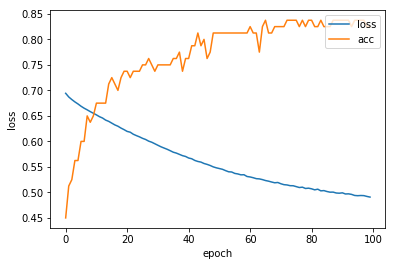

In [46]:
import matplotlib.pyplot as plt

plt.plot(hist.history["loss"])
plt.plot(hist.history["acc"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["loss", "acc"], loc="upper right")
plt.show()

# Logistic Regression

In [42]:
from sklearn import linear_model


In [43]:
y_train = y_train.as_matrix()
y_train = np.squeeze(y_train)
y_train.shape



(80,)

In [44]:
model = linear_model.LogisticRegression()
model = model.fit(X_train, y_train)



In [45]:
# check the accuracy on the training set
model.score(X_test, y_test)

0.625